<a href="https://colab.research.google.com/github/JM3309/Projects/blob/master/covid_19_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

This task is related to the covid-19 image classification model and prediction.






The dataset comes from kaggle data which includes 3 types of X-ray images covid-19,normal and viral pneumonia. 

[data source](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database?select=COVID-19+Radiography+Database)




This file includes 5 parts:

1. Dataset description and visualize datset 

2. Data prepoccessing

3. Build and fine-tune deep learning model(Resnet50/VGG16)

4. Evaluate trained deep learning model

5. Test model and prediction evaluation


# 1.IMPORT LIBRARIES AND DATASET


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm
import shutil
 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
 from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot"

test  train


#### Dataset description

In [ ]:
total_cnt = 0
for files in {'COVID-19','NORMAL','Viral Pneumonia'}:
    for file in os.listdir(os.path.join('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot',files)):
        total_cnt+=1

print('The total number of Images: {}'.format(total_cnt))


In [ ]:
COVID19_cnt = 0
NORMAL_cnt = 0
Viral_Pneumonia_cnt = 0
for files in {'COVID-19'}:
    for file in os.listdir(os.path.join('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot',files)):
        COVID19_cnt += 1
for files in {'NORMAL'}:
    for file in os.listdir(os.path.join('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot',files)):
        NORMAL_cnt += 1
for files in {'Viral Pneumonia'}:
    for file in os.listdir(os.path.join('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot',files)):
        Viral_Pneumonia_cnt += 1                

print('The number of COVID-19 Images: {}'.format(COVID19_cnt))
print('The number of NORMAL Images: {}'.format(NORMAL_cnt))
print('The number of Viral_Pneumonia Images: {}'.format(Viral_Pneumonia_cnt))

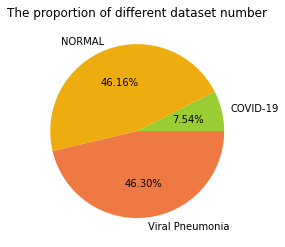

In [71]:
# draw a pie plot
labels=['COVID-19','NORMAL','Viral Pneumonia']
X=[219,1341,1345]  
color = ['#9ACD32','#EEAD0E','#EE7942'] 

fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%',colors=color) 
plt.title("The proportion of different dataset number")
plt.show() 


#### VISUALIZE DATASET

In [14]:
#label translator
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia'}

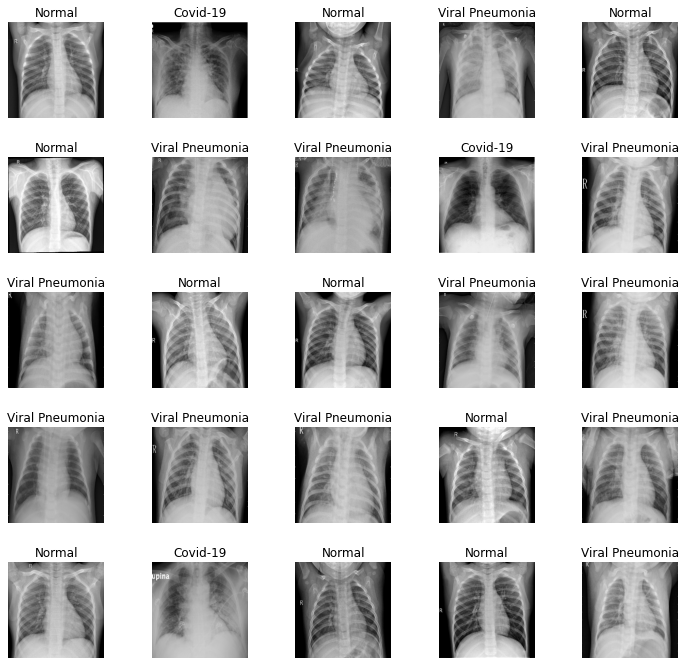

In [15]:
 # Create a grid of 25 images along with their corresponding labels
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)  

# 2.DATA PREPOCCESSING

In [ ]:
# setting path
src = '/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/train'
dst = '/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test'
os.mkdir('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/COVID-19')
os.mkdir('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/Viral Pneumonia')
os.mkdir('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/NORMAL')

In [ ]:
for folders in os.listdir(src):
    num_files = len(os.listdir(os.path.join(src,folders)))
    cut_length = int(num_files*0.2)
    cnt=0
    for files in os.listdir(os.path.join(src,folders)):
        shutil.move(os.path.join(src, folders, files), os.path.join(dst, folders, files))
        if(cnt==cut_length):
            break
        cnt+=1

In [ ]:
train_cnt = 0
os.listdir(src)
for file in {'COVID-19', 'NORMAL', 'Viral Pneumonia'}:
    for files in os.listdir(os.path.join(src,file)):
            train_cnt+=1
train_cnt

In [ ]:
test_cnt=0
os.listdir(dst)
for file in {'COVID-19', 'NORMAL', 'Viral Pneumonia'}:
    for files in os.listdir(os.path.join(dst,file)):
            test_cnt+=1
test_cnt

In [6]:
XRay_Directory = '/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/train'

In [7]:
os.listdir(XRay_Directory)

['Viral Pneumonia', 'NORMAL', 'COVID-19']

Use 20% of the data for cross-validation

In [8]:
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [9]:

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory,
                            shuffle= True, target_size=(256,256), 
                            class_mode = 'categorical', subset="training")
 

Found 1858 images belonging to 3 classes.


In [10]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 464 images belonging to 3 classes.


In [11]:
train_images, train_labels = next(train_generator)

In [72]:
train_labels.shape

(40, 3)

In [73]:
train_images.shape

(40, 256, 256, 3)

# 3.BUILD AND TRAIN DEEP LEARNING MODEL

## Hyperparameter


In [16]:
lr = 1e-4
loss1 = 'categorical_crossentropy'
epoch = 10
dropout = 0.3
activation1 = 'relu'
activation2 = 'softmax'

##  RESNET50 MODEL

In [17]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
# basemodel.summary()

In [19]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [20]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256,activation=activation1)(headmodel)
headmodel = Dropout(dropout)(headmodel)
headmodel = Dense(256,activation=activation1)(headmodel)
headmodel = Dropout(dropout)(headmodel) 
headmodel = Dense(3, activation = activation2)(headmodel)


In [21]:
model1 = Model(inputs = basemodel.input, outputs = headmodel)

In [22]:
model1.compile(loss=loss1,
        optimizer=optimizers.RMSprop(learning_rate=lr),
        metrics = ["accuracy"])

In [23]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [24]:
train_generator = image_generator.flow_from_directory(batch_size = 3, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 3, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 1858 images belonging to 3 classes.
Found 464 images belonging to 3 classes.


In [25]:
history = model1.fit_generator(train_generator, 
                 steps_per_epoch= train_generator.n // 4, 
                 epochs = epoch, 
                 validation_data= val_generator, 
                 validation_steps= val_generator.n // 4, 
                 callbacks=[checkpointer, 
                 earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
464/464 [==============================] - ETA: 0s - loss: 0.4673 - accuracy: 0.8642
Epoch 00001: val_loss improved from inf to 8.70052, saving model to weights.hdf5
464/464 [==============================] - 653s 1s/step - loss: 0.4673 - accuracy: 0.8642 - val_loss: 8.7005 - val_accuracy: 0.0805
Epoch 2/10
464/464 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9345
Epoch 00002: val_loss improved from 8.70052 to 4.52697, saving model to weights.hdf5
464/464 [==============================] - 197s 424ms/step - loss: 0.2766 - accuracy: 0.9345 - val_loss: 4.5270 - val_accuracy: 0.3362
Epoch 3/10
464/464 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9612
Epoch 00003: val_loss improved from 4.52697 to 0.21173, saving model to weights.hdf5
464/464 [==============================] - 74s 159ms/step - loss: 0.1856 - accuracy: 0.9612 - val_loss: 0.2117 - val_a

## VGG16 MODEL

In [26]:
basemodel1 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

58892288/58889256 [==============================] - 1s 0us/step


In [27]:
# basemodel1.summary()

In [28]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel1.layers[:-10]:
  layers.trainable = False

In [29]:
headmodel1 = basemodel1.output
headmodel1 = AveragePooling2D(pool_size=(4,4))(headmodel1)
headmodel1 = Flatten(name='flatten')(headmodel1)
headmodel1 = Dense(256,activation=activation1)(headmodel1)
headmodel1 = Dropout(dropout)(headmodel1)
headmodel1 = Dense(256,activation=activation1)(headmodel1)
headmodel1 = Dropout(dropout)(headmodel1) 
headmodel1 = Dense(3, activation = activation2)(headmodel1)

In [30]:
model2 = Model(inputs = basemodel1.input, outputs = headmodel1)

In [31]:
model2.compile(loss=loss1,
        optimizer=optimizers.RMSprop(learning_rate=lr),
        metrics = ["accuracy"])

In [32]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer1 = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [33]:
history2 = model2.fit_generator(train_generator, 
                 steps_per_epoch= train_generator.n // 4, 
                 epochs = epoch, 
                 validation_data= val_generator, 
                 validation_steps= val_generator.n // 4, 
                 callbacks=[checkpointer1, 
                 earlystopping1])

Epoch 1/10
464/464 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.7086
Epoch 00001: val_loss improved from inf to 0.74496, saving model to weights.hdf5
464/464 [==============================] - 48s 103ms/step - loss: 0.7487 - accuracy: 0.7086 - val_loss: 0.7450 - val_accuracy: 0.6523
Epoch 2/10
464/464 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8561
Epoch 00002: val_loss improved from 0.74496 to 0.24848, saving model to weights.hdf5
464/464 [==============================] - 46s 99ms/step - loss: 0.4558 - accuracy: 0.8561 - val_loss: 0.2485 - val_accuracy: 0.9138
Epoch 3/10
464/464 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8863
Epoch 00003: val_loss improved from 0.24848 to 0.18798, saving model to weights.hdf5
464/464 [==============================] - 46s 100ms/step - loss: 0.4138 - accuracy: 0.8863 - val_loss: 0.1880 - val_accuracy: 0.9540
Epoch 4/10
464/464 [==============================] - ETA: 0

# 4.EVALUATE TRAINED DEEP LEARNING MODEL

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

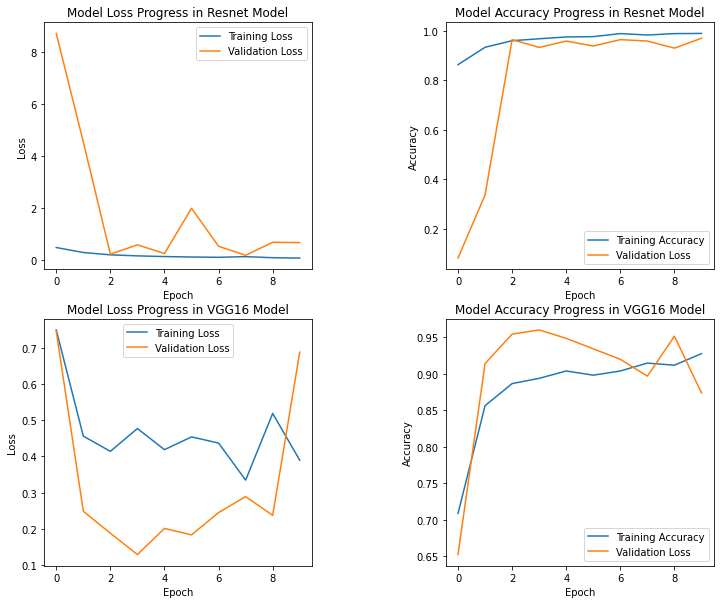

In [57]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes = axes.ravel()

"""

Resnet model

"""
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Progress in Resnet Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress in Resnet Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Loss'])

"""

VGG16 model

"""
plt.subplot(2, 2, 3)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('Model Loss Progress in VGG16 Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.subplot(2, 2, 4)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy Progress in VGG16 Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Loss'])
plt.subplots_adjust(wspace = 0.5) 

# 5.TEST MODEL AND PREDICTION EVALUATION

In [40]:
test_directory = '/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test'

In [ ]:
#Rename the file
os.rename('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/COVID-19','/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/0')
os.rename('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/NORMAL','/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/1')
os.rename('/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/Viral Pneumonia','/content/drive/My Drive/ml_projects/covid-19 recognition/x_ray_plot/test/2')


In [42]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')


Found 583 images belonging to 3 classes.


In [58]:
# TEST ON RESNET MODEL
evaluate1 = model1.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate1[1]))

 15/145 [==>...........................] - 253s 17s/step - loss: 0.3083 - accuracy: 0.9657
Accuracy Test : 0.9656946659088135


In [59]:
# TEST ON VGG16 MODEL
evaluate2 = model2.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate2[1]))

 15/145 [==>...........................] - 12s 768ms/step - loss: 0.9421 - accuracy: 0.8868
Accuracy Test : 0.8867924809455872


In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction_resnet = []
original_resnet = []
image_resnet = []
prediction_vgg = []
original_vgg = []
image_vgg = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))

    image_resnet.append(img)
    image_vgg.append(img)

    img = img / 255
    img = img.reshape(-1,256,256,3)

    predict_resnet = model1.predict(img)
    predict_resnet = np.argmax(predict_resnet)
    prediction_resnet.append(predict_resnet)
    predict_vgg = model2.predict(img)
    predict_vgg = np.argmax(predict_vgg)
    prediction_vgg.append(predict_vgg)

    original_resnet.append(i)
    original_vgg.append(i)

In [64]:
print("The classification report for Resnet model:","\n","\n",classification_report(np.asarray(original_resnet), np.asarray(prediction_resnet)),"\n","\n")


print("The classification report for VGG16 model:","\n","\n",classification_report(np.asarray(original_vgg), np.asarray(prediction_vgg)))

The classification report for Resnet model: 
 
               precision    recall  f1-score   support

           0       0.95      0.84      0.89        44
           1       0.97      0.98      0.97       269
           2       0.97      0.98      0.98       270

    accuracy                           0.97       583
   macro avg       0.96      0.93      0.95       583
weighted avg       0.97      0.97      0.97       583
 
 

The classification report for VGG16 model: 
 
               precision    recall  f1-score   support

           0       0.96      0.61      0.75        44
           1       0.85      0.99      0.91       269
           2       0.93      0.84      0.88       270

    accuracy                           0.89       583
   macro avg       0.91      0.81      0.85       583
weighted avg       0.89      0.89      0.89       583



Text(0.5, 1.0, 'Confusion_matrix in VGG16 Model')

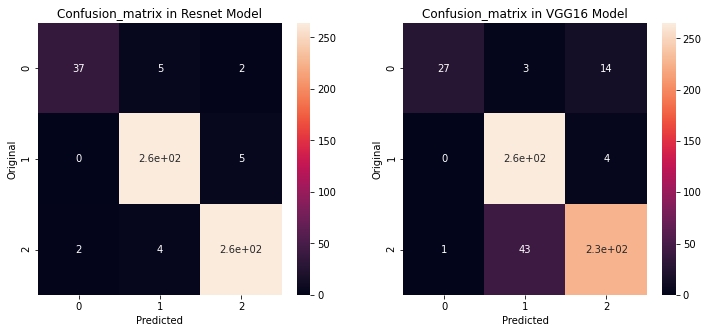

In [74]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
axes = axes.ravel()

"""

Resnet Model

"""

cm1 = confusion_matrix(np.asarray(original_resnet), np.asarray(prediction_resnet))
ax1 = plt.subplot(1,2,1)
sns.heatmap(cm1, annot = True, ax = ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Original')
ax1.set_title('Confusion_matrix in Resnet Model')

"""

VGG16 Model

"""

cm2 = confusion_matrix(np.asarray(original_vgg), np.asarray(prediction_vgg))
ax2 = plt.subplot(1,2,2)
sns.heatmap(cm2, annot = True, ax = ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Original')
ax2.set_title('Confusion_matrix in VGG16 Model')


Resnet model performs better than the VGG16 model